In [1]:
import multiSyncPy as msp
from sktime.utils.plotting import plot_correlations
from multiSyncPy import synchrony_metrics as sm
from scipy.signal import hilbert
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_functions import get_ant_datafiles_info, preprocess_antcolony_data
from multisync_functions import get_multisync_metrics, get_multisync_statistics
from IPython.display import display

ant_colonies = get_ant_datafiles_info()
ant_colonies

,recording_location,file,location,n_ants,species_name,enterance
0,indoor,dataset/ants/IndoorDataset/Seq0001Object10Imag...,china,10,japanese_arched_ant,0
1,indoor,dataset/ants/IndoorDataset/Seq0002Object10Imag...,china,10,japanese_arched_ant,0
2,indoor,dataset/ants/IndoorDataset/Seq0003Object10Imag...,china,10,japanese_arched_ant,0
3,indoor,dataset/ants/IndoorDataset/Seq0004Object10Imag...,china,10,japanese_arched_ant,0
4,indoor,dataset/ants/IndoorDataset/Seq0005Object10Imag...,china,10,japanese_arched_ant,0
5,outdoor,dataset/ants/OutdoorDataset/Seq0006Object21Ima...,russia,73,carpenter_ant,1
6,outdoor,dataset/ants/OutdoorDataset/Seq0007Object26Ima...,greece,162,little_black_ant,1
7,outdoor,dataset/ants/OutdoorDataset/Seq0008Object31Ima...,russia,133,carpenter_ant,1
8,outdoor,dataset/ants/OutdoorDataset/Seq0009Object50Ima...,russia,193,carpenter_ant,1
9,outdoor,dataset/ants/OutdoorDataset/Seq0010Object30Ima...,usa,101,little_black_ant,0


In [2]:

# take a single "trial" (one group of ants moving through time and space) as an example
example_data = ant_colonies['file'][0]
ants = preprocess_antcolony_data(example_data)

# this one has the ant_id as the index
ant_dict = {ant_id: ants[ants['ant_id'] == ant_id] for ant_id in ants['ant_id'].unique()}

print(f"Number of unique ants: {ants['ant_id'].nunique()}")

Number of unique ants: 10


In [3]:
# a starting approach can be to investigate one single ant only:
# ant_11 = ant_dict[11]
# plot_correlations(ant_11['x'])
# plt.show()

Coherence: 0.14483338190959055
Symbolic entropy: 4.127137193429166
Rho: 0.9801752887280589


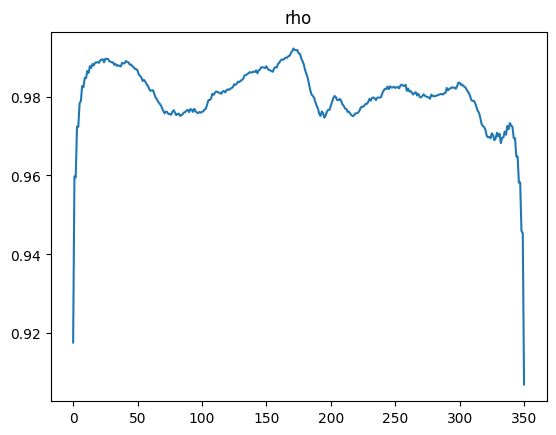

In [4]:
# try "multivariate synchrony" approaches
ant_team_data = np.array([ant_data['x'].values for ant_data in ant_dict.values()])
data_phases = np.angle(hilbert(ant_team_data))

print(f"Coherence: {sm.coherence_team(ant_team_data)}")
print(f"Symbolic entropy: {sm.symbolic_entropy(ant_team_data)}")
print(f"Rho: {sm.rho(data_phases)[1]}")

plt.plot(sm.rho(data_phases)[0])
plt.title('rho')
plt.show()

Ant group investigation, contrasting multisync measurements (coherence, symbolic entropy, rho) between different groups (inside ant groups vs outside ant groups)

In [5]:
# get all metrics for all ant colonies on a certain target variable (ant x or y position) and compare indoor and outdoor ants
preprocessed_colonies = [preprocess_antcolony_data(colony) for colony in ant_colonies['file'].tolist()]
metrics = [get_multisync_metrics(colony, target_var='x', n_observations_per_unit=100, id_column='ant_id') for colony in preprocessed_colonies]
coherence, symbolic_entropy, rho = zip(*metrics)

ant_colonies['coherence'] = coherence
ant_colonies['symbolic_entropy'] = symbolic_entropy
ant_colonies['rho'] = rho

In [6]:
# compare indoor and outdoor ants
indoor = ant_colonies[ant_colonies['recording_location'] == 'indoor']
outdoor = ant_colonies[ant_colonies['recording_location'] == 'outdoor']

# by adding the coherence measurements for each ant group, we can compare indoor and outdoor ants
results = get_multisync_statistics(indoor, outdoor)
display(results)


,Metric,T-test (p-value),T-test (statistic),Mann-Whitney U (p-value),Mann-Whitney U (statistic)
0,coherence,0.595820,-0.552318,1.000000,12.0
1,symbolic_entropy,0.005914,3.715013,0.015873,24.0
2,rho,0.016535,3.020968,0.031746,23.0


In [7]:
c_metrics = []
for i, colony in enumerate(preprocessed_colonies):
    print(f"Colony {i}")
    for n_per_unit in range(10, 100, 10):
        metrics = get_multisync_metrics(colony, target_var='x', n_observations_per_unit=n_per_unit, id_column='ant_id')
        c_metrics.append((i, n_per_unit, ant_colonies['recording_location'][i], *metrics))

    
df = pd.DataFrame(c_metrics, columns=['colony_id', 'n_per_unit', 'recording_location', 'coherence', 'symbolic_entropy', 'rho'])

Colony 0
Colony 1
Colony 2
Colony 3
Colony 4
Colony 5
Colony 6
Colony 7
Colony 8


c:\Users\zxx_D\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\signal\_spectral_py.py:1626: RuntimeWarning: invalid value encountered in divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy


Colony 9


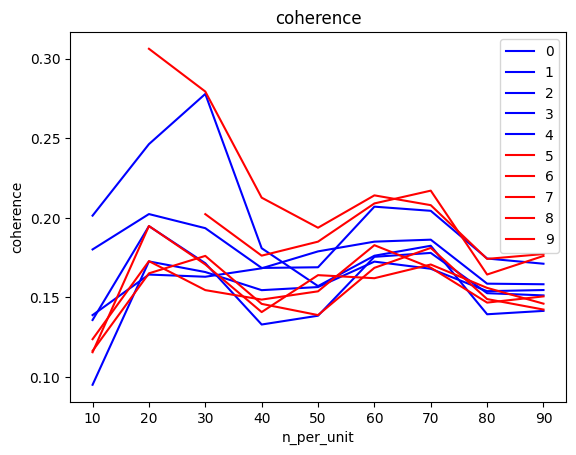

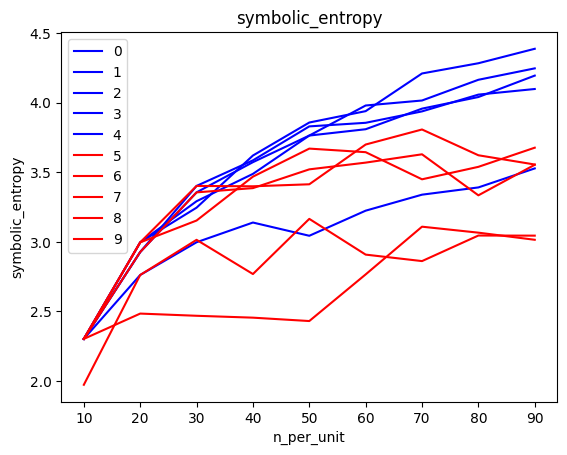

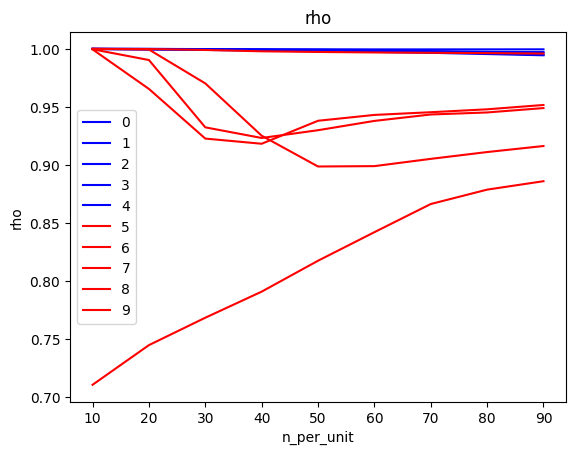

In [8]:
def plot_metrics(df, metric_name):
    for name, group in df.groupby('colony_id'):
        plt.plot(group['n_per_unit'], group[metric_name], label=name, color='blue' if group['recording_location'].iloc[0] == 'indoor' else 'red')
    plt.title(metric_name)
    plt.xlabel('n_per_unit')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

plot_metrics(df, 'coherence')
plot_metrics(df, 'symbolic_entropy')
plot_metrics(df, 'rho')

Bird flocking investigation, contrasting multisync measurements (coherence, symbolic entropy, rho) between different groups (not grouped birds vs grouped birds)

In [9]:
from data_functions import process_bird_data
from os.path import isfile
import zipfile

if not isfile('dataset/birds/birds_grouped.csv'):
    with zipfile.ZipFile('dataset/birds/birds_grouped.zip', 'r') as zip_ref:
        zip_ref.extractall('dataset/birds')

birds = pd.read_csv('dataset/birds/birds_grouped.csv')
birds_processed_0 = process_bird_data(birds, selected_class=0, target_col_pre='x')
birds_processed_1 = process_bird_data(birds, selected_class=1, target_col_pre='x')

total = min(len(birds_processed_0), len(birds_processed_1))
birds_processed = birds_processed_0[:total] + birds_processed_1[:total]
    
birds_processed = pd.DataFrame(birds_processed, columns=['scene', 'class', 'coherence', 'symbolic_entropy', 'rho'])
display(birds_processed)

ungrouped = birds_processed[birds_processed['class'] == 0]
grouped = birds_processed[birds_processed['class'] == 1]

results = get_multisync_statistics(ungrouped, grouped)
display(results)

,scene,class,coherence,symbolic_entropy,rho
0,0,0,0.179624,5.043566,0.246256
1,1,0,0.183185,4.689891,0.319813
2,2,0,0.179688,4.778566,0.321288
3,3,0,0.175689,4.637633,0.244672
4,4,0,0.176064,4.574029,0.246588
5,5,0,0.181382,4.568310,0.234800
6,6,0,0.176437,4.696244,0.252569
7,7,0,0.176910,4.720687,0.242254
8,8,0,0.180865,4.736153,0.198863
9,9,0,0.183717,4.683235,0.284099


,Metric,T-test (p-value),T-test (statistic),Mann-Whitney U (p-value),Mann-Whitney U (statistic)
0,coherence,5.776525e-10,-11.899627,0.000183,0.0
1,symbolic_entropy,4.319427e-03,3.263046,0.000769,95.0
2,rho,2.092336e-13,-19.119548,0.000183,0.0
